=== 各地区【实际】中位数（Homework 3.3） ===


,地区,房价中位数(元/㎡),租金中位数(元/㎡),中位数售租比
0,beitapingzhuang,89942.528736,127.703488,704.307532
1,shijicheng,110303.030303,107.558140,1025.520066
2,wanliu,148027.432607,151.898734,974.513931
3,suzhoujie,79571.759259,126.491228,629.069387


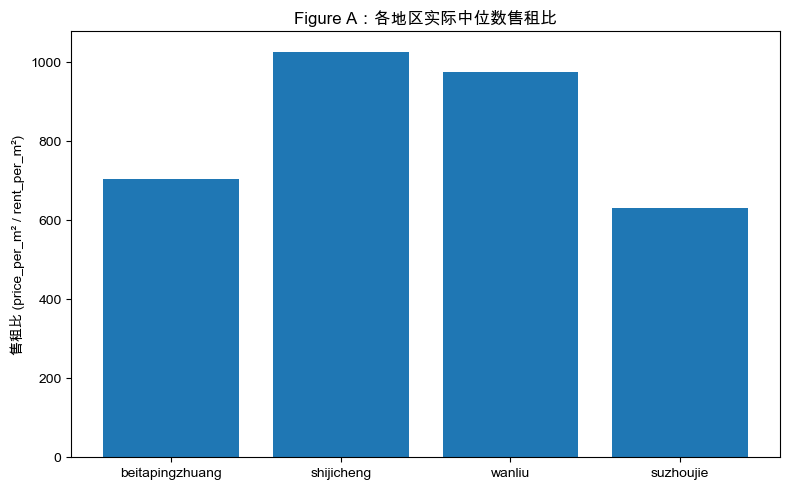

当前工作目录： /Users/cristiano/Untitled Folder 1
目录下的 Excel 文件：
 - shijicheng_housingprice.xlsx
 - shijicheng_housingrent.xlsx
 - 万柳二手房数据.xlsx
 - 万柳租房数据.xlsx
 - 二手房数据.xlsx
 - 北太平庄二手房数据.xlsx
 - 北太平庄租房数据.xlsx
 - 租房数据.xlsx
 - 苏州街二手房数据.xlsx
 - 苏州街租房数据.xlsx

识别到总数据文件：
  总价(万)文件：二手房数据.xlsx
  租金文件   ：租房数据.xlsx


=== 线性模型（不含 location） ===
Price: price_per_m2 = 74285.4879 + 252.1464 * 面积
Rent : rent_per_m2  = 117.9363 + 0.1062 * 面积

=== 各地区【预测】中位数（Homework 3.4） ===


,地区,预测房价中位数(元/㎡),预测租金中位数(元/㎡),预测中位数售租比
0,beitapingzhuang,97858.659325,123.886170,789.907856
1,shijicheng,115889.651822,135.042203,858.173589
2,wanliu,118904.062608,137.007789,867.863521
3,suzhoujie,91156.606737,124.417410,732.667612


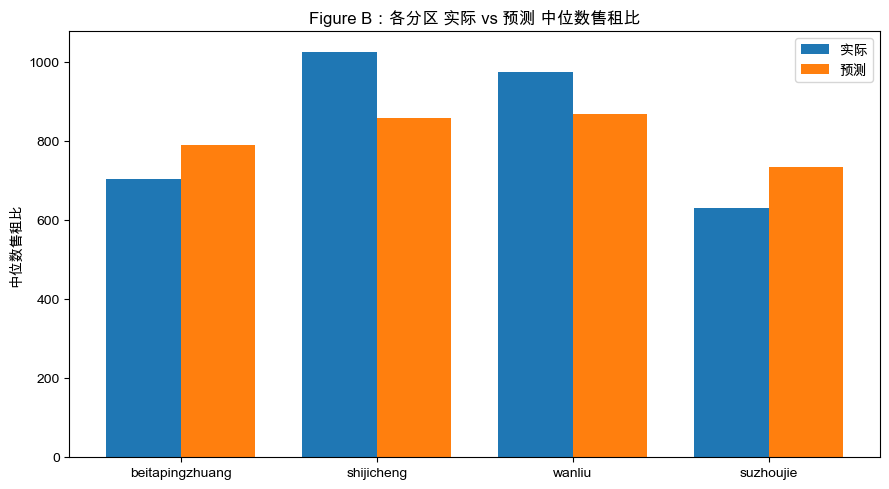

In [4]:
# =========================================================
#  Homework 3.3 & 3.4  — 一次跑通（含自动发现总数据文件）
# =========================================================

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS','PingFang SC','Heiti SC']
plt.rcParams['axes.unicode_minus'] = False

# ---------- 1) 四个分区：8 个文件 ----------
REGION_FILES = {
    "beitapingzhuang": {
        "price": "北太平庄二手房数据.xlsx",
        "rent" : "北太平庄租房数据.xlsx"
    },
    "shijicheng": {
        "price": "shijicheng_housingprice.xlsx",
        "rent" : "shijicheng_housingrent.xlsx"
    },
    "wanliu": {
        "price": "万柳二手房数据.xlsx",
        "rent" : "万柳租房数据.xlsx"
    },
    "suzhoujie": {
        "price": "苏州街二手房数据.xlsx",
        "rent" : "苏州街租房数据.xlsx"
    }
}

# 你原先设想的两个总数据文件名（先尝试用它们）
CANDIDATE_TOTAL_PRICE = "三千房数据.xlsx"
CANDIDATE_TOTAL_RENT  = "租房数据.xlsx"


# ---------- 2) 健壮读取/清洗 ----------
def load_and_process(path: str, kind: str):
    """
    读取 Excel，自动识别“面积/总价(或租金)”列；标准化为['面积','总价','price_per_m2']
    kind: 'price'（总价单位视为“万”） 或 'rent'（自动判断“万/元月”）
    """
    df_raw = pd.read_excel(path)
    df_raw = df_raw.dropna(how='all', axis=0).dropna(how='all', axis=1)
    df_raw = df_raw.loc[:, [c for c in df_raw.columns if str(c).strip() != '' and 'Unnamed' not in str(c)]]

    def find_col(cands):
        for c in df_raw.columns:
            s = str(c)
            if any(k in s for k in cands):
                return c
        return None

    area_col  = find_col(['面积'])
    price_col = find_col(['总价','租金'])

    if area_col is None or price_col is None:
        if df_raw.shape[1] < 2:
            raise ValueError(f"文件 {path} 有效列不足两列，检测到列：{list(df_raw.columns)}")
        area_col, price_col = df_raw.columns[:2].tolist()

    df = df_raw[[area_col, price_col]].copy()
    df.columns = ['面积', '总价']

    def to_num(x):
        if pd.isna(x): 
            return np.nan
        s = str(x)
        s = (s.replace(',', '')
               .replace('㎡','').replace('平米','')
               .replace('元/月','').replace('元','')
               .replace('万','').strip())
        try:
            return float(s)
        except:
            return np.nan

    df['面积'] = df['面积'].apply(to_num)
    df['总价'] = df['总价'].apply(to_num)
    df = df.dropna(subset=['面积','总价'])
    df = df[(df['面积'] > 0) & (df['总价'] > 0)]

    if kind == 'price':
        df['price_per_m2'] = df['总价'] * 10000.0 / df['面积']
    else:
        # 若数值很小（<=200），多半也是“万”为单位（部分租金整表被误写为“总价(万)”）
        scale = 10000.0 if df['总价'].median() <= 200 else 1.0
        df['price_per_m2'] = df['总价'] * scale / df['面积']

    return df.reset_index(drop=True)


# ---------- 3) 自动发现“总数据”两个文件 ----------
def discover_total_files(region_files: dict,
                         candidate_price: str,
                         candidate_rent: str):
    """
    返回 (total_price_file, total_rent_file)
    逻辑：
    1) 若 candidate 文件存在，直接用；
    2) 否则在当前目录扫描 *.xlsx，剔除 8 个分区文件，剩下的视为“总数据”候选。
       - 若候选有 2 个：尝试用内容特征区分“价格（万）”与“租金（元/月/万）”：
           * 价格（万）→ 每平米价格数值通常更大；也可用“文件名含'租'”优先判定为租金表
       - 若候选不止 2 个：再用文件名关键字筛选（含“租”/“price”/“rent”等）
    """
    # 打印当前目录与文件，便于核对
    print("当前工作目录：", os.getcwd())
    print("目录下的 Excel 文件：")
    xlsx_all = sorted([os.path.basename(p) for p in glob.glob("*.xlsx")])
    for f in xlsx_all:
        print(" -", f)

    # 8 个分区文件名集合
    region_file_set = set()
    for paths in region_files.values():
        region_file_set.add(paths['price'])
        region_file_set.add(paths['rent'])

    # 1) 先尝试候选名
    price_file = candidate_price if os.path.exists(candidate_price) else None
    rent_file  = candidate_rent  if os.path.exists(candidate_rent)  else None

    # 2) 如果其中有缺失，自动发现
    if not price_file or not rent_file:
        # 剩余非分区文件
        leftovers = [f for f in xlsx_all if f not in region_file_set]
        # 如果候选存在一个，保留之并从 leftovers 移除
        if price_file and price_file in leftovers: leftovers.remove(price_file)
        if rent_file  and rent_file  in leftovers: leftovers.remove(rent_file)

        # 优先根据文件名关键字判断租金
        rent_like = [f for f in leftovers if any(k in f.lower() for k in ['租','rent'])]
        price_like = [f for f in leftovers if any(k in f.lower() for k in ['价','price','二手','房']) and f not in rent_like]

        # 尝试填充
        if not rent_file and rent_like:
            rent_file = rent_like[0]
        if not price_file and price_like:
            price_file = price_like[0]

        # 仍有缺失：用内容特征再判一次
        if (not price_file or not rent_file) and len(leftovers) >= 2:
            # 取前两个做启发式判别
            candA, candB = leftovers[0], leftovers[1]
            # 用“每平米价格”的中位数大小来粗分：更大者多半是“售价(万→元)”
            try:
                dfA_price = load_and_process(candA, 'price')
                medA = dfA_price['price_per_m2'].median()
            except Exception:
                medA = -1
            try:
                dfB_price = load_and_process(candB, 'price')
                medB = dfB_price['price_per_m2'].median()
            except Exception:
                medB = -1

            if medA >= 0 and medB >= 0:
                if medA >= medB:
                    price_file = price_file or candA
                    rent_file  = rent_file  or candB
                else:
                    price_file = price_file or candB
                    rent_file  = rent_file  or candA

    if not price_file or not rent_file:
        raise FileNotFoundError(
            f"无法识别总数据文件，请核对：\n"
            f"- 期望价格总数据（默认名）：{candidate_price}\n"
            f"- 期望租金总数据（默认名）：{candidate_rent}\n"
            f"或确保目录中仅多出这两个总数据 .xlsx（且不属于四个分区的 8 个文件）。"
        )

    print(f"\n识别到总数据文件：\n  总价(万)文件：{price_file}\n  租金文件   ：{rent_file}\n")
    return price_file, rent_file


# ---------- 4) 先做四个分区的“实际”中位数售租比（Homework 3.3） ----------
summary_rows = []
region_dfs_price, region_dfs_rent = {}, {}

for region, paths in REGION_FILES.items():
    df_p = load_and_process(paths['price'], 'price')
    df_r = load_and_process(paths['rent'] , 'rent')
    region_dfs_price[region] = df_p
    region_dfs_rent [region] = df_r

    med_p = df_p['price_per_m2'].median()
    med_r = df_r['price_per_m2'].median()
    ratio = med_p / med_r if med_r != 0 else np.nan
    summary_rows.append([region, med_p, med_r, ratio])

actual_df = pd.DataFrame(summary_rows,
                         columns=['地区','房价中位数(元/㎡)','租金中位数(元/㎡)','中位数售租比'])
print("=== 各地区【实际】中位数（Homework 3.3） ===")
display(actual_df)

plt.figure(figsize=(8,5))
plt.bar(actual_df['地区'], actual_df['中位数售租比'])
plt.title('Figure A：各地区实际中位数售租比')
plt.ylabel('售租比 (price_per_m² / rent_per_m²)')
plt.tight_layout(); plt.show()


# ---------- 5) 自动发现并读取“总数据”，建线性模型（Homework 3.4，location不入模） ----------
total_price_file, total_rent_file = discover_total_files(
    REGION_FILES, CANDIDATE_TOTAL_PRICE, CANDIDATE_TOTAL_RENT
)

total_price_df = load_and_process(total_price_file, 'price')
total_rent_df  = load_and_process(total_rent_file , 'rent')

X_price = total_price_df[['面积']].values
y_price = total_price_df['price_per_m2'].values
X_rent  = total_rent_df [['面积']].values
y_rent  = total_rent_df ['price_per_m2'].values

model_price = LinearRegression().fit(X_price, y_price)
model_rent  = LinearRegression().fit(X_rent , y_rent)

print("\n=== 线性模型（不含 location） ===")
print(f"Price: price_per_m2 = {model_price.intercept_:.4f} + {model_price.coef_[0]:.4f} * 面积")
print(f"Rent : rent_per_m2  = {model_rent.intercept_:.4f} + {model_rent.coef_[0]:.4f} * 面积")


# ---------- 6) 用总数据模型对各分区逐条预测 → 分区“预测中位数售租比” ----------
pred_rows = []
for region in REGION_FILES.keys():
    dfp = region_dfs_price[region].copy()
    dfr = region_dfs_rent [region].copy()
    dfp['pred_price_per_m2'] = model_price.predict(dfp[['面积']].values)
    dfr['pred_rent_per_m2']  = model_rent .predict(dfr[['面积']].values)

    med_pred_p = np.median(dfp['pred_price_per_m2'].values)
    med_pred_r = np.median(dfr['pred_rent_per_m2'].values)
    pred_ratio = med_pred_p / med_pred_r if med_pred_r != 0 else np.nan

    pred_rows.append([region, med_pred_p, med_pred_r, pred_ratio])

pred_df = pd.DataFrame(pred_rows,
                       columns=['地区','预测房价中位数(元/㎡)','预测租金中位数(元/㎡)','预测中位数售租比'])
print("\n=== 各地区【预测】中位数（Homework 3.4） ===")
display(pred_df)

# Figure B：实际 vs 预测
plot_df = actual_df[['地区','中位数售租比']].merge(
    pred_df[['地区','预测中位数售租比']], on='地区'
).rename(columns={'中位数售租比':'实际','预测中位数售租比':'预测'})

x = np.arange(len(plot_df)); w = 0.38
plt.figure(figsize=(9,5))
plt.bar(x - w/2, plot_df['实际'], width=w, label='实际')
plt.bar(x + w/2, plot_df['预测'], width=w, label='预测')
plt.xticks(x, plot_df['地区'])
plt.ylabel('中位数售租比')
plt.title('Figure B：各分区 实际 vs 预测 中位数售租比')
plt.legend(); plt.tight_layout(); plt.show()


=== R² on TOTAL DATA ===
Price  (linear) : R² = 0.3064
Price  (quadr.) : R² = 0.3064
Rent   (linear) : R² = 0.0384
Rent   (quadr.) : R² = 0.0418

--- Price models (coefficients) ---
Linear:  y = 74285.4879 + 252.1464 * area
Quadr.:  y = 74682.4146 + 247.4225 * area + 0.011242 * area^2

--- Rent models (coefficients) ---
Linear:  y = 117.9363 + 0.1062 * area
Quadr.:  y = 114.1484 + 0.1448 * area + -0.000059 * area^2

=== 各地区：一次 vs 二次 模型的售租比（中位数） ===


,地区,一次模型售租比(中位数),二次模型售租比(中位数)
0,beitapingzhuang,789.907856,802.078635
1,shijicheng,858.173589,851.935928
2,wanliu,867.863521,859.432633
3,suzhoujie,732.667612,743.611353


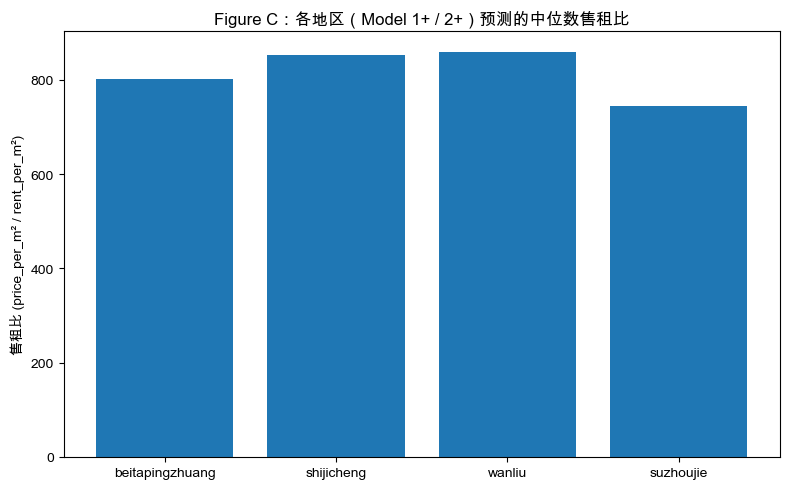

In [5]:
# =========================
# HW3-5: 非线性（二次项）+ 交互的简化版（这里只做二次项）
# 输出 R^2，并用二次模型对四个地区预测 → Figure C
# =========================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) 准备总数据的特征：一次 & 二次 ---
# 价格
Xp_lin = total_price_df[['面积']].values
yp = total_price_df['price_per_m2'].values
Xp_quad = np.c_[Xp_lin, Xp_lin**2]          # [面积, 面积^2]

# 租金
Xr_lin = total_rent_df[['面积']].values
yr = total_rent_df['price_per_m2'].values
Xr_quad = np.c_[Xr_lin, Xr_lin**2]

# --- 2) 训练一次与二次模型，并输出 R^2 ---
m_price_lin = LinearRegression().fit(Xp_lin, yp)
m_price_quad = LinearRegression().fit(Xp_quad, yp)

m_rent_lin = LinearRegression().fit(Xr_lin, yr)
m_rent_quad = LinearRegression().fit(Xr_quad, yr)

# R^2
r2_price_lin  = m_price_lin.score(Xp_lin, yp)
r2_price_quad = m_price_quad.score(Xp_quad, yp)
r2_rent_lin   = m_rent_lin.score(Xr_lin, yr)
r2_rent_quad  = m_rent_quad.score(Xr_quad, yr)

print("=== R² on TOTAL DATA ===")
print(f"Price  (linear) : R² = {r2_price_lin:.4f}")
print(f"Price  (quadr.) : R² = {r2_price_quad:.4f}")
print(f"Rent   (linear) : R² = {r2_rent_lin:.4f}")
print(f"Rent   (quadr.) : R² = {r2_rent_quad:.4f}")

# 可选：也输出系数，便于 PPT 展示
print("\n--- Price models (coefficients) ---")
print(f"Linear:  y = {m_price_lin.intercept_:.4f} + {m_price_lin.coef_[0]:.4f} * area")
print(f"Quadr.:  y = {m_price_quad.intercept_:.4f} + "
      f"{m_price_quad.coef_[0]:.4f} * area + {m_price_quad.coef_[1]:.6f} * area^2")
print("\n--- Rent models (coefficients) ---")
print(f"Linear:  y = {m_rent_lin.intercept_:.4f} + {m_rent_lin.coef_[0]:.4f} * area")
print(f"Quadr.:  y = {m_rent_quad.intercept_:.4f} + "
      f"{m_rent_quad.coef_[0]:.4f} * area + {m_rent_quad.coef_[1]:.6f} * area^2")

# --- 3) 用“一次 & 二次”模型对四个地区逐条预测，得到各地区的中位数售租比 ---
rows = []
for region in region_dfs_price.keys():
    dfp = region_dfs_price[region].copy()
    dfr = region_dfs_rent [region].copy()

    area_p = dfp[['面积']].values
    area_r = dfr[['面积']].values

    # 一次预测
    dfp['pred_price_lin'] = m_price_lin.predict(area_p)
    dfr['pred_rent_lin']  = m_rent_lin.predict(area_r)

    # 二次预测
    dfp['pred_price_quad'] = m_price_quad.predict(np.c_[area_p, area_p**2])
    dfr['pred_rent_quad']  = m_rent_quad.predict(np.c_[area_r, area_r**2])

    # 各地区“预测中位数售租比”
    ratio_lin  = np.median(dfp['pred_price_lin'])  / np.median(dfr['pred_rent_lin'])
    ratio_quad = np.median(dfp['pred_price_quad']) / np.median(dfr['pred_rent_quad'])

    rows.append([region, ratio_lin, ratio_quad])

ratio_compare_df = pd.DataFrame(rows, columns=['地区','一次模型售租比(中位数)','二次模型售租比(中位数)'])
print("\n=== 各地区：一次 vs 二次 模型的售租比（中位数） ===")
display(ratio_compare_df)

# --- 4) Figure C：用 “二次模型(1+ / 2+)” 的预测售租比画柱状图 ---
plt.figure(figsize=(8,5))
plt.bar(ratio_compare_df['地区'], ratio_compare_df['二次模型售租比(中位数)'])
plt.title('Figure C：各地区（Model 1+ / 2+）预测的中位数售租比')
plt.ylabel('售租比 (price_per_m² / rent_per_m²)')
plt.tight_layout()
plt.show()
